# **Course Rating Prediction using Neural Networks**


### Object


* Use `tensorflow` to train neural networks to extract the user and item latent features from the hidden's layers  
* Predict course ratings with trained neural networks


----


## Prepare and setup lab environment


In [1]:
# install tensorflow if you do not have it installed for any reason
#!pip install tensorflow

and import required libraries:


In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# also set a random state
rs = 123

### <font color=salmon>Load and processing rating dataset


In [3]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


<font color=salmon size=4>This is the same rating dataset we have been using in previous lab, which contains the three main columns: `user`, `item`, and `rating`. 


<font color=salmon size=4>Next, let's figure out how many unique users and items, their total numbers will determine the sizes of one-hot encoding vectors.


In [4]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


<font color=salmon size=4>It means our each user can be represented as a `33901 x 1` one-hot vector and each item can be represented as `126 x 1` one-hot vector.


<font color=salmon size=4>The goal is to create a neural network structure that can take the user and item one-hot vectors as inputs and outputs a rating estimation or the probability of interaction (such as the probability of completing a course). 

<font color=salmon size=4>While training and updating the weights in the neural network, its hidden layers should be able to capture the pattern or features for each user and item. Based on this idea, we can design a simple neural network architecture like the following:


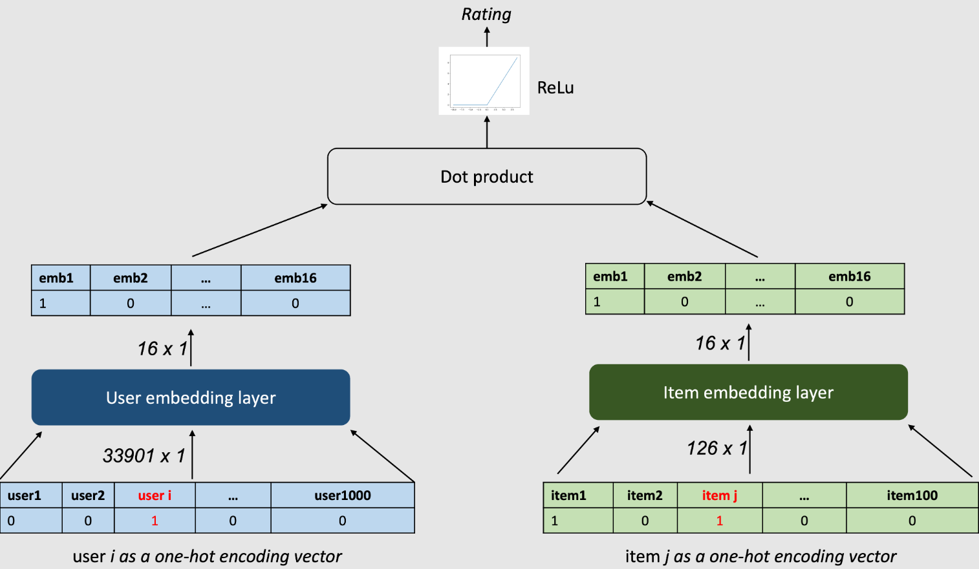

<font color=salmon size=4>The network inputs are two one-hot encoding vectors, the blue one is for the user and the green one is for the item. Then on top of them, we added two embedding layers. Here embedding means embedding the one-hot encoding vector into a latent feature space. The embedding layer is a fully-connected layer that outputs the embedding feature vectors. For example, the user embedding layer takes `33901 x 1` one-hot vector as input and outputs a `16 x 1` embedding vector.


<font color=salmon size=4>The embedding layer outputs two embedding vectors, which are similar to Non-negative matrix factorization. Then we could simply dot the product the user and item embedding vector to output a rating estimation.


## Implementing the recommender neural network using tensorflow 


<font color=salmon size=4>This network architecture could be defined and implemented as a sub-class inheriting the `tensorflow.keras.Model` super class, let's call it `RecommenderNet()`.


In [5]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)

### TASK: Train and evaluate the RecommenderNet()


<font color=salmon size=4>Now it's time to train and evaluate the defined `RecommenderNet()`. First, we need to process the original rating dataset a little bit by converting the actual user ids and item ids into integer indices for `tensorflow` to creating the one-hot encoding vectors.


In [6]:
def process_dataset(raw_data):
    
    encoded_data = raw_data.copy()
    
    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [7]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [8]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


<font color=salmon size=4>Then we can split the encoded dataset into training and testing datasets.


In [9]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [10]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

<font color=salmon size=4>If we take a look at the training input data, it is simply just a list of user indices and item indices, which is a dense format of one-hot encoding vectors.


In [11]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973], dtype=int64)

In [12]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17], dtype=int64)

<font color=salmon size=4>and training output labels are a list of 0s and 1s indicating if the user has completed a course or not:


In [13]:
y_train

array([1., 1., 1., ..., 1., 0., 1.])

<font color=salmon size=4>Then we can choose a small embedding vector size to be 16 and create a `RecommenderNet()` model to be trained


In [14]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

<font color=salmon size=4>_TODO: Train the RecommenderNet() model_


Epoch 1/10
2917/2917 [==============================] - 55s 18ms/step - loss: 0.1365 - root_mean_squared_error: 0.3690 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2066
Epoch 2/10
2917/2917 [==============================] - 51s 18ms/step - loss: 0.0399 - root_mean_squared_error: 0.1981 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1886
Epoch 3/10
2917/2917 [==============================] - 52s 18ms/step - loss: 0.0285 - root_mean_squared_error: 0.1659 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1650
Epoch 4/10
2917/2917 [==============================] - 53s 18ms/step - loss: 0.0220 - root_mean_squared_error: 0.1442 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1511
Epoch 5/10
2917/2917 [==============================] - 53s 18ms/step - loss: 0.0181 - root_mean_squared_error: 0.1294 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1419
Epoch 6/10
2917/2917 [==============================] - 53s 18ms/step - loss: 0.0155 - root_mean_squared_error: 0.1184 -

INFO:tensorflow:Assets written to: my_model_20230313\assets


INFO:tensorflow:Assets written to: my_model_20230313\assets


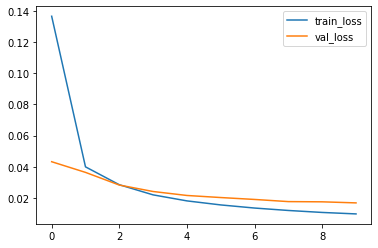

In [15]:
## WRITE YOUR CODE HERE:

## - call model.compile() method to set up the loss and optimizer and metrics 
#for the model training, you may use

##  - - tf.keras.losses.MeanSquaredError() as training loss
##  - - keras.optimizers.Adam() as optimizer
##  - - tf.keras.metrics.RootMeanSquaredError() as metric

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

## - call model.fit() to train the model
# avagy "train the model"
history = model.fit(
    x=x_train, 
    y=y_train, 
    batch_size=64, 
    epochs=10, 
    validation_data=(x_val, y_val), 
    verbose=1
)


## - optionally call model.save() to save the model
model.save("my_model_20230313", save_format="tf")

## - plot the train and validation loss
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

<font color=salmon size=4>_TODO:_ Evaluate the trained model


In [16]:
### WRITE YOUR CODE HERE

### - call model.evaluate() to evaluate the model

# Evaluate the trained model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Print the test loss and accuracy
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)


730/730 [==============================] - 2s 3ms/step - loss: 0.0161 - root_mean_squared_error: 0.1198
Test loss: 0.016092969104647636
Test accuracy: 0.119815893471241


### <font color=salmon>Extract the user and item embedding vectors as latent feature vectors


<font color=salmon size=4>Now, we have trained the `RecommenderNet()` model and it can predict the ratings with relatively small RMSE. 

<font color=salmon size=4>If we print the trained model then we can see its layers and their parameters/weights.


In [17]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding_layer (Embed  multiple                 542416    
 ding)                                                           
                                                                 
 user_bias (Embedding)       multiple                  33901     
                                                                 
 item_embedding_layer (Embed  multiple                 2016      
 ding)                                                           
                                                                 
 item_bias (Embedding)       multiple                  126       
                                                                 
Total params: 578,459
Trainable params: 578,459
Non-trainable params: 0
_________________________________________________________________


<font size=4 color='orange'>In the `RecommenderNet`, the `user_embedding_layer` and `item_embedding_layer` layers contain the trained weights. Essentially, they are the latent user and item features learned by `RecommenderNet` and will be used to predict the interaction. As such, while training the neural network to predict rating, the embedding layers are simultaneously trained to extract the embedding user and item features.


<font color=salmon size=4>We can easily get the actual weights using `model.get_layer().get_weights()` methods


In [18]:
# User features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 16)


In [19]:
user_latent_features[0]

array([ 0.06747788,  0.091557  , -0.17394468,  0.09984368, -0.01127258,
        0.07473863, -0.10978845,  0.00554118, -0.03222223, -0.0164851 ,
        0.05656017,  0.0035417 , -0.0067942 , -0.11888792,  0.06216373,
       -0.00080346], dtype=float32)

In [20]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 16)


In [21]:
item_latent_features[0]

array([ 0.00043688,  0.00136984,  0.01579627,  0.00628351,  0.00722139,
        0.01846576,  0.00251413, -0.00115957, -0.00356877, -0.00114702,
        0.02901372,  0.00875282, -0.01752442, -0.0122087 , -0.00277572,
       -0.01524407], dtype=float32)

<font color=salmon size=4>Now, each user of the total 33901 users has been transformed into a 16 x 1 latent feature vector and each item of the total 126 has been transformed into a 16 x 1 latent feature vector.


### TASK (Optional): Customize the RecommenderNet to potentially improve the model performance


<font color=salmon size=4>The pre-defined `RecommenderNet()` is a actually very basic neural network, you are encouraged to customize it to see if model prediction performance will be improved. Here are some directions:
- <font color=salmon size=4>Hyperparameter tuning, such as the embedding layer dimensions
- <font color=salmon size=4>Add more hidden layers
- <font color=salmon size=4>Try different activation functions such as `ReLu`


In [22]:
## WRITE YOUR CODE HERE

## Update RecommenderNet() class

## compile and fit the updated model

## evaluate the updated model

class ImprovedRecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=32, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(ImprovedRecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
        # Add more hidden layers with ReLU activation
        self.hidden_layer_1 = layers.Dense(64, activation='relu')
        self.hidden_layer_2 = layers.Dense(32, activation='relu')
        
        # Output layer with sigmoid activation
        self.output_layer = layers.Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        
        # Add more hidden layers with ReLU activation
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        
        # Output layer with sigmoid activation
        return self.output_layer(x)



Epoch 1/10
2917/2917 [==============================] - 55s 18ms/step - loss: 0.0333 - root_mean_squared_error: 0.1815 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1634
Epoch 2/10
2917/2917 [==============================] - 51s 18ms/step - loss: 0.0256 - root_mean_squared_error: 0.1574 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1545
Epoch 3/10
2917/2917 [==============================] - 55s 19ms/step - loss: 0.0181 - root_mean_squared_error: 0.1294 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1454
Epoch 4/10
2917/2917 [==============================] - 54s 18ms/step - loss: 0.0116 - root_mean_squared_error: 0.0990 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1327
Epoch 5/10
2917/2917 [==============================] - 54s 19ms/step - loss: 0.0076 - root_mean_squared_error: 0.0748 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1302
Epoch 6/10
2917/2917 [==============================] - 55s 19ms/step - loss: 0.0059 - root_mean_squared_error: 0.0622 -

INFO:tensorflow:Assets written to: my_model2_20230313\assets


INFO:tensorflow:Assets written to: my_model2_20230313\assets


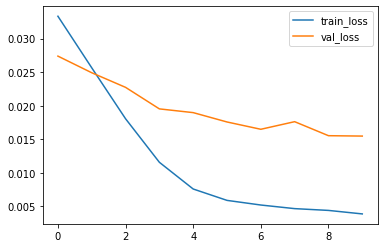

In [23]:
embedding_size = 16
model2 = ImprovedRecommenderNet(num_users, num_items, embedding_size)

model2.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

## - call model.fit() to train the model
history2 = model2.fit(
    x=x_train, 
    y=y_train, 
    batch_size=64, 
    epochs=10, 
    validation_data=(x_val, y_val), 
    verbose=1
)


## - optionally call model.save() to save the model
model2.save("my_model2_20230313", save_format="tf")

## - plot the train and validation loss
plt.plot(history2.history["loss"], label="train_loss")
plt.plot(history2.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [24]:
# Evaluate the trained model on the test set
test_loss, test_accuracy = model2.evaluate(x_test, y_test)

# Print the test loss and accuracy
print("Test loss on model2:", test_loss)
print("Test accuracy on model2:", test_accuracy)

730/730 [==============================] - 2s 3ms/step - loss: 0.0140 - root_mean_squared_error: 0.1113
Test loss on model2: 0.013956747949123383
Test accuracy on model2: 0.1113140806555748


In [25]:
train_loss, train_accuracy = model2.evaluate(x_train, y_train)
print("Training loss on model2:", train_loss)
print("Training accuracy on model2:", train_accuracy)

5833/5833 [==============================] - 19s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0377
Training loss on model2: 0.002986303996294737
Training accuracy on model2: 0.03768811374902725


<font color=salmon size=5>
>Note that the accuracy metric may not be relevant for regression tasks as it is usually used for classification tasks. In this case, the training loss metric is a more appropriate metric for evaluating the model's performance on the training data.